# Initial Mass Function (IMF)

`airball` provides an initial mass function class `IMF` for randomly generating stellar masses for different stellar environments. "The initial mass function (IMF) is an empirical function that describes the initial distribution of masses for a population of stars during star formation" [(wikipedia)](https://en.wikipedia.org/wiki/Initial_mass_function).

First we import `airball`, `numpy`, and `matplotlib`. We also make sure to use a colour blind friendly palette.

In [1]:
import airball
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Basics

The default IMF uses a piecewise combination of Salpeter (1955) for $m \geq 1\,M_\odot$ and Chabrier (2003) for single stars for $m < 1\,M_\odot$.

In [2]:
# Create an IMF with a specified mass range and default mass function
imf = airball.IMF(min_mass=0.08, max_mass=8)

# Generate a random mass from the IMF
random_mass = imf.random_mass()
print(random_mass)  # Output: e.g., 0.2319633663071667 solMass

1.1274294967766794 solMass


In [3]:
# Generate 5 random masses from the IMF
random_mass = imf.random_mass(size=5)
print(random_mass)  # Output: e.g., [1.1002683  0.94606418 0.7699541  1.1230717  0.13752477] solMass

[0.1676936  0.23215658 0.09626256 0.23364812 0.24709727] solMass


In [4]:
# Compute the median mass for the IMF
imf.median_mass # Output: e.g., 0.22984008 solMass

<Quantity 0.22984008 solMass>

## Providing your own IMF

You can provide your own IMF when initializing an instance of the class by passing a function to the `mass_function` parameter. The following examples use an IMF using Salpeter (1955) for the entire mass range or have a uniform IMF. The IMF you provide should be a probability density function (PDF). `airball` will normalize the PDF for you over the given mass range. You can define an IMF as a standard python function or as a lambda function. Let's also set different mass ranges for each mass function.

In [5]:
# Define an IMF based on Salpeter (1955) and a (unphysical) uniform IMF.
def salpeter55(x): return x**-2.3
uniform = lambda x: 1

# Create an IMF with a specified mass range and default mass function
salpeter55_imf = airball.IMF(min_mass=0.1, max_mass=5, mass_function=salpeter55)
uniform_imf = airball.IMF(min_mass=0.01, max_mass=10, mass_function=uniform)

# Generate some random masses from the IMFs
print(salpeter55_imf.random_mass(5)) # Output: e.g., [2.13009562 0.10366307 0.91977187 0.11607485 0.11049281] solMass
print(uniform_imf.random_mass(5)) # Output: e.g., [4.81040127 4.13340906 3.64267182 3.37830285 3.81484321] solMass

[0.15304844 0.25237891 0.13377779 0.31297268 0.67779354] solMass
[0.95484031 1.08554114 8.79979518 3.90075813 7.87282702] solMass


In [6]:
# Compute the median masses for the IMFs
print(f'Salpeter (1955) median mass: {salpeter55_imf.median_mass:1.5f}')
print(f'Uniform PDF median mass: {uniform_imf.median_mass:1.5f}')

Salpeter (1955) median mass: 0.16970 solMass
Uniform PDF median mass: 5.00500 solMass


We can visually compare the different distributions by plotting their PDFs. We can also see how the generating function corresponds to the PDF. For convenience, if we need to, we can call the `IMF.masses` function to generate a `numpy.logspace` array over the IMF mass range. This is especially useful when you want to bin samples over many orders of magnitude. However, `airball` will also automatically set the regions outside of the mass range to be zero for the PDF (and 0 or 1 for the CDF).

In [7]:
nsamples = 100_000
default_samples = imf.random_mass(nsamples).value
salpeter55_samples = salpeter55_imf.random_mass(nsamples).value
uniform_samples = uniform_imf.random_mass(nsamples).value

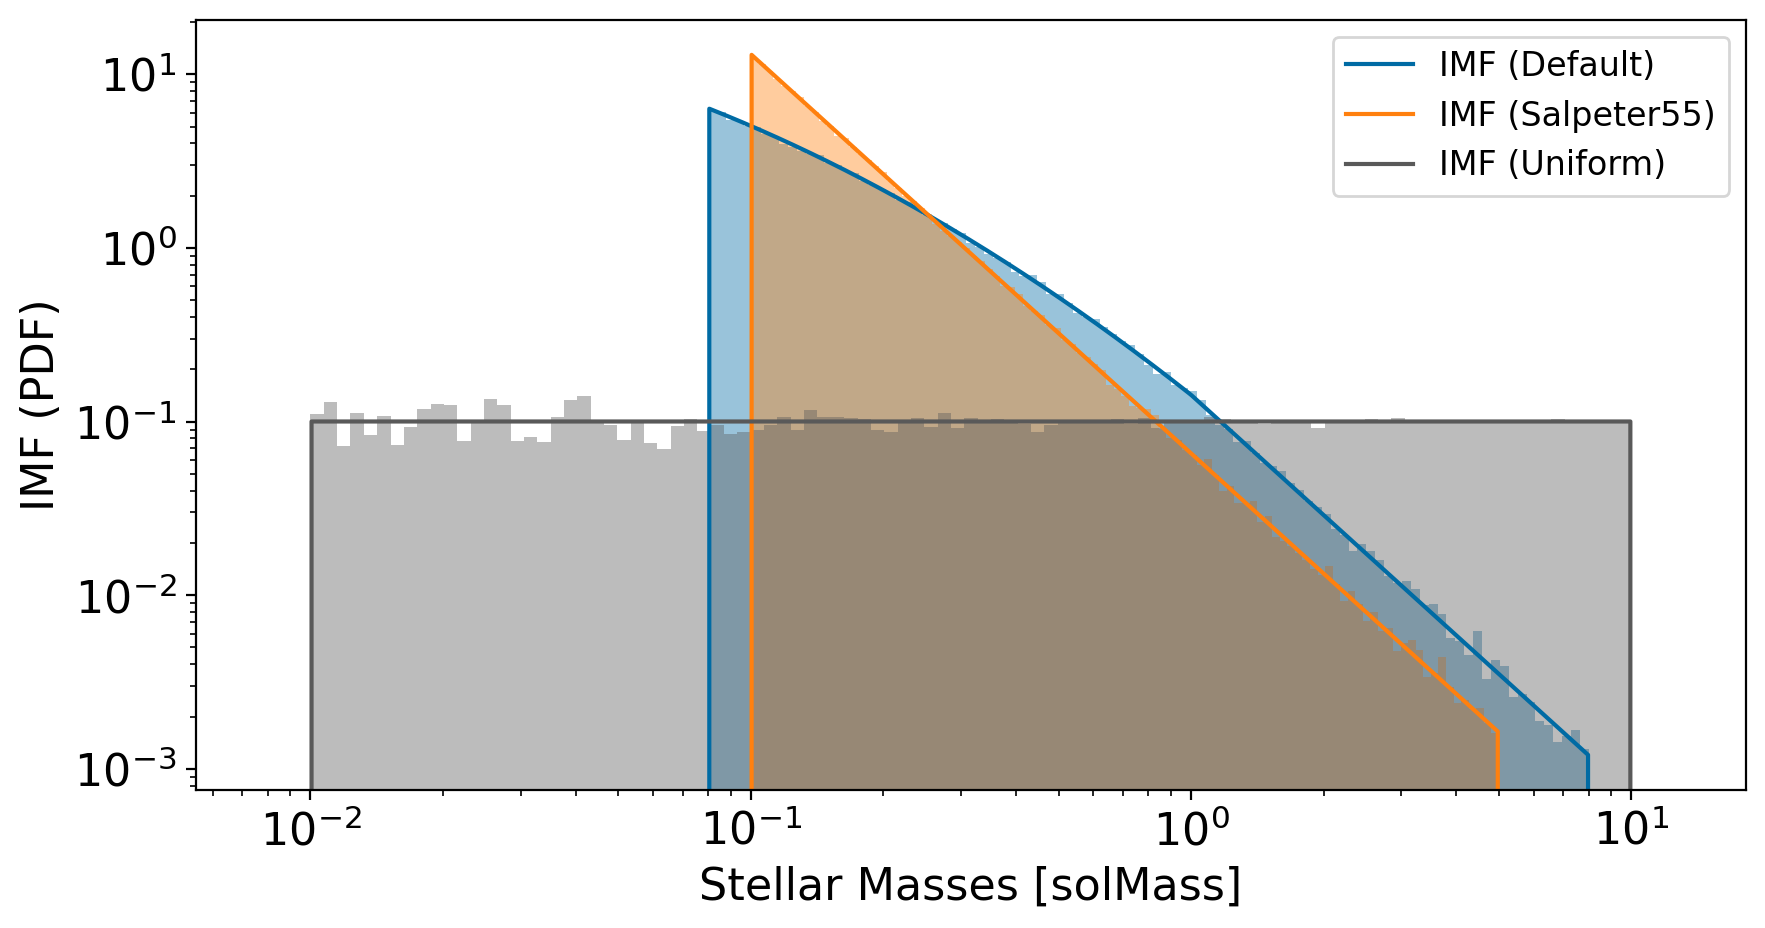

In [8]:
nbins = 100
npoints = 1000
ms = np.logspace(-2.1,1.1, npoints)

plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(default_samples, bins=imf.masses(nbins), density=True, color='C0', alpha=0.4)
ax.hist(salpeter55_samples, bins=salpeter55_imf.masses(nbins), density=True, color='C1', alpha=0.4)
ax.hist(uniform_samples, bins=uniform_imf.masses(nbins), density=True, color='C3', alpha=0.4)

ax.loglog(ms, imf.pdf(ms), 'C0', label='IMF (Default)')
ax.loglog(ms, salpeter55_imf.pdf(ms), 'C1', label='IMF (Salpeter55)')
ax.loglog(ms, uniform_imf.pdf(ms), 'C3', label='IMF (Uniform)')

ax.legend(prop={'size': 12})
ax.set_xlabel(f'Stellar Masses [{imf.unit}]')
ax.set_ylabel('IMF (PDF)')
plt.show()

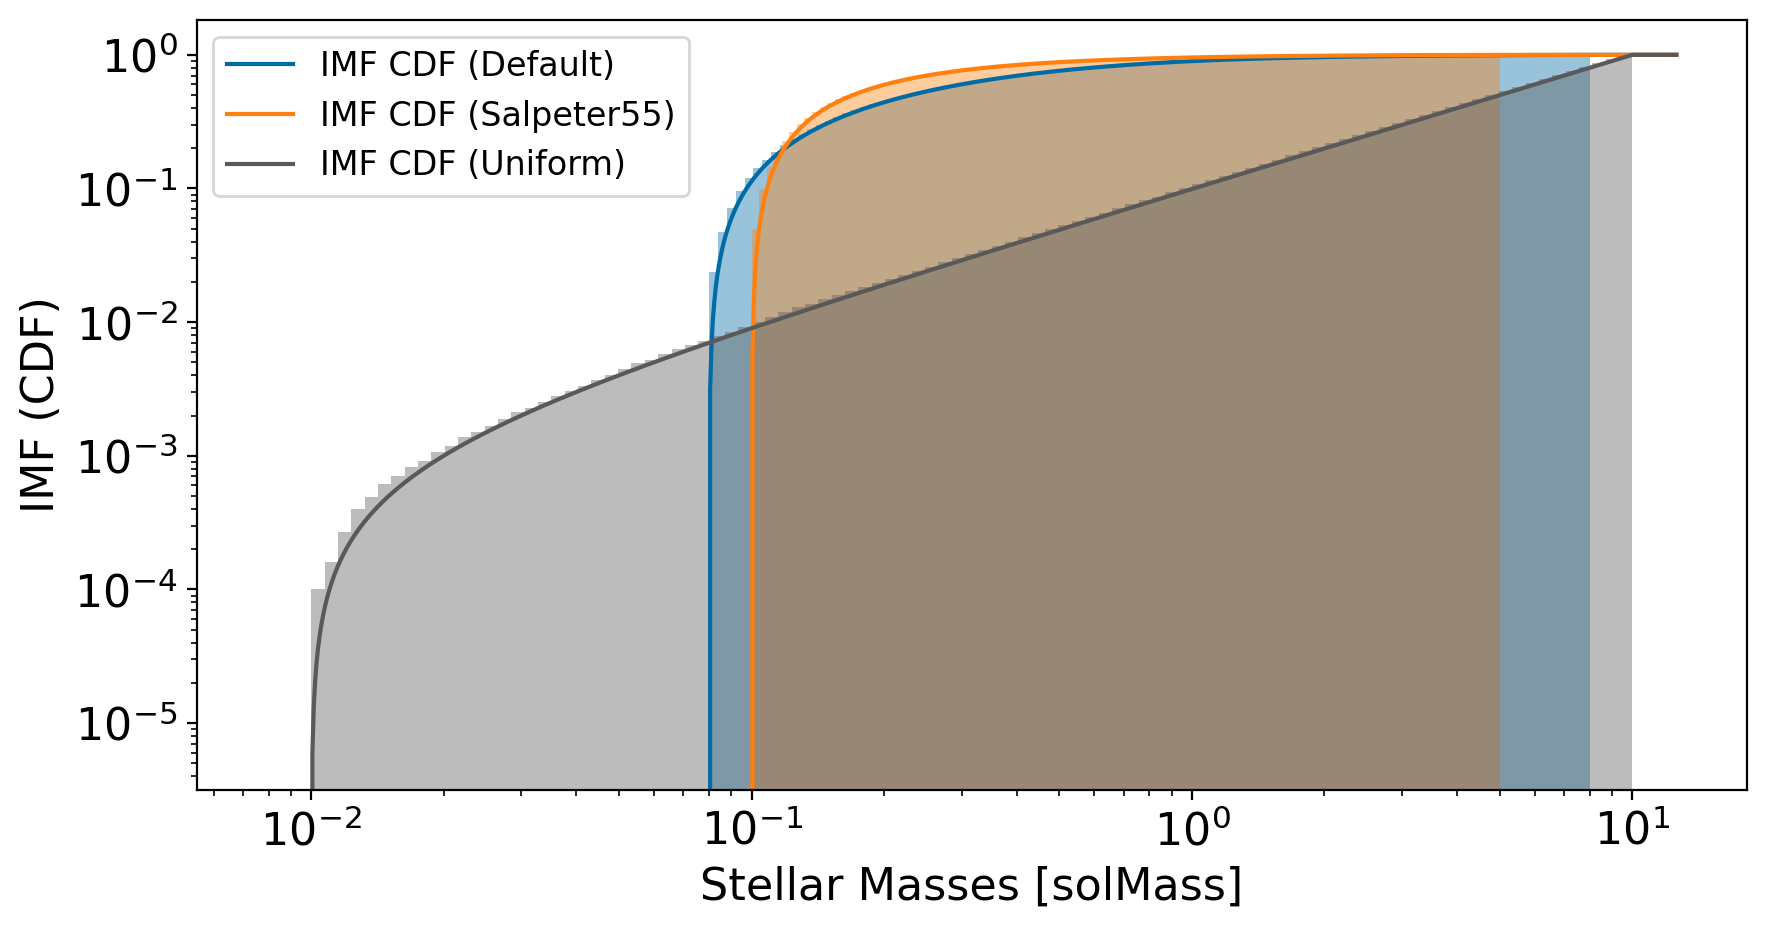

In [9]:
plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1, figsize=(10,5))

ax.loglog(ms, imf.cdf(ms), 'C0', label='IMF CDF (Default)')
ax.loglog(ms, salpeter55_imf.cdf(ms), 'C1', label='IMF CDF (Salpeter55)')
ax.loglog(ms, uniform_imf.cdf(ms), 'C3', label='IMF CDF (Uniform)')

ax.hist(imf.random_mass(nsamples).value, bins=imf.masses(nbins), density=True, cumulative=True, color='C0', alpha=0.4)
ax.hist(salpeter55_imf.random_mass(nsamples).value, bins=salpeter55_imf.masses(nbins), density=True, cumulative=True, color='C1', alpha=0.4)
ax.hist(uniform_imf.random_mass(nsamples).value, bins=uniform_imf.masses(nbins), density=True, cumulative=True, color='C3', alpha=0.4)

ax.legend(loc=2, prop={'size': 12})
ax.set_xlabel(f'Stellar Masses [{imf.unit}]')
ax.set_ylabel('IMF (CDF)')
plt.show()

## Possible Issues
The `IMF` class uses `scipy.integrate.quad` to normalize the PDF and compute the CDF. So if the PDF is unwieldy the integration may not converge. In order to process the CDF more quickly, `airball` uses `numpy.interp`. The default number of samples used to compute the CDF is 100. This can be changed when initializing the `IMF` or afterwards by setting the `number_samples` property. When the property is updated `airball` recalculates the PDF and CDF, just like when the minimum and maximum masses are changed. If you find that interpolating with 100 samples is not precise enough for you, then you can increase the value. However, this can take a very long time even for not that many samples.

In [10]:
imf.number_samples = 2500 # Takes ~20s to run.

In [11]:
# Takes ~40s to run.
npts = 12
pts = np.logspace(np.log10(3), np.log10(2000), npts)
avg_rel_err = np.zeros(npts)
high_res = imf.cdf(imf.masses(npoints))[1:]
for i,n in enumerate(pts):
    imf.number_samples = int(n)
    # skip over the first value in the CDF when we compute the relative error because it is identically zero.
    avg_rel_err[i] = np.nanmean(np.abs((imf.cdf(imf.masses(npoints))[1:] - high_res)/high_res))

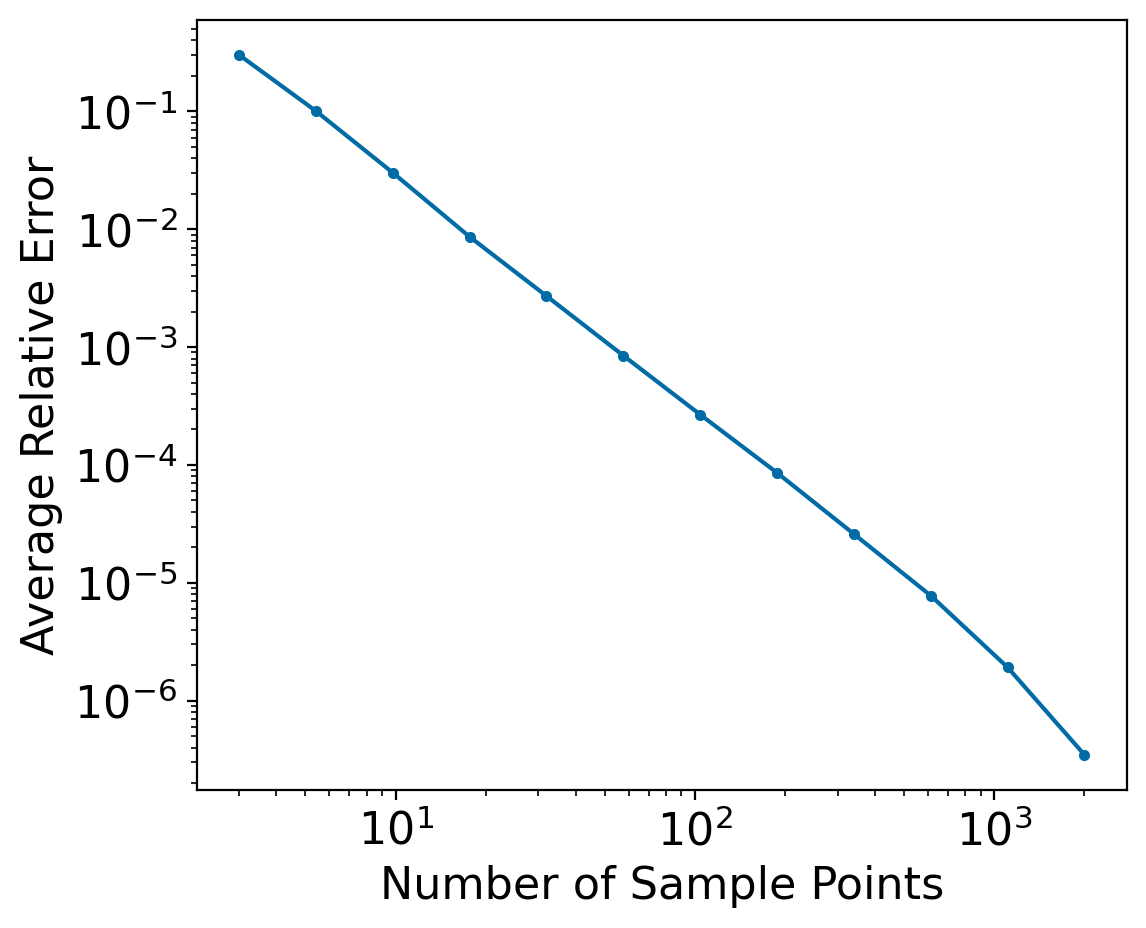

In [12]:
plt.rcParams.update({'font.size': 16})
fig,ax = plt.subplots(1,1, figsize=(6,5))
ax.loglog(pts, avg_rel_err, '.-')
ax.set_xlabel(f'Number of Sample Points')
ax.set_ylabel('Average Relative Error')
plt.show()